<h2>Daniel Vasilyonok</h2>
<h3>Python for Data Science CSCI E - 29</h3>
<h3>Natural Language Identification Machine Learning Pipeline - Graduate Project</h3>

<p>
In this project, I pulled text data from European Parliament Proceedings in 21 languages.
Using Scikit-Learn, I transformed the raw text into a numerical feature matrix, and trained
a Multinomial naive bayes probability model to classify input language with greater than 99% accuracy.
</p>

<p> 
Data Source: http://www.statmt.org/europarl/    
</p>

In [237]:

# Required libraries

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import re
from nltk.tokenize import sent_tokenize
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
import os
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd

In [238]:

# regular expression pattern used to filter out anything between < >
# Non predictive speaker information in english is always in between those two symbols

pattern = r'<(!?).*>'

# Max length of language transcription
# Ensure each language has similar amount of representation (Balanced Dataset)
MAX_LENGTH_TRANSCRIPTION = 150000

In [239]:

# Map language index to natural language

labels = { 
          1.0:'Danish', 2.0:'German',
          3.0: 'Greek', 4.0: 'English', 
          5.0: 'Spanish',6.0: 'Finnish', 
          7.0: 'French', 8.0: 'Italian', 
          9.0: 'Dutch', 10.0: 'Portuguese', 
          11.0: 'Swedish', 12.0: 'Bulgarian',
          13.0: 'Czech', 14.0: 'Estonian',
          15.0: 'Hungarian', 16.0: 'Lithuanian',
          17.0: 'Latvian', 18.0: 'Polish',
          19.0: 'Romanian', 20.0: 'Slovak',
          21.0: 'Slovenian'
          }

# Map language to language code and file name

language_codes_files = {
    'Danish': ['da', '/ep-00-01-17.txt'], 'German': ['de', '/ep-00-01-17.txt'], 
    'Greek': ['el', '/ep-00-01-17.txt'], 'English': ['en', '/ep-00-01-17.txt'], 
    'Spanish': ['es', '/ep-00-01-17.txt'], 'Finnish': ['fi', '/ep-00-01-17.txt'],
    'French': ['fr','/ep-00-01-17.txt'], 'Italian': ['it', '/ep-00-01-17.txt'], 
    'Dutch': ['nl', '/ep-00-01-17.txt'], 'Portuguese': ['pt', '/ep-00-01-17.txt'], 
    'Swedish': ['sv', '/ep-00-01-17.txt'], 'Bulgarian': ['bg', '/Bulgarian.txt'],
    'Czech': ['cs', '/Czech.txt'], 'Estonian': ['et', '/Estonian.txt'],
    'Hungarian': ['hu', '/Hungarian.txt'], 'Lithuanian': ['lt', '/Lithuanian.txt'],
    'Latvian': ['lv', '/Latvian.txt'], 'Polish': ['pl', '/Polish.txt'],
    'Romanian': ['ro', '/Romanian.txt'], 'Slovak': ['sk', '/Slovak.txt'],
    'Slovenian': ['sl', '/Slovenian.txt']
}

# These languages need multiple files combined to get a transcription of length
# >= MAX_LENGTH_TRANSCRIPTION
limited_raw_text = ['Bulgarian', 'Czech', 'Estonian', 'Hungarian', 'Lithuanian',
                     'Latvian', 'Polish', 'Romanian', 'Slovak', 'Slovenian']


<h2>Helper Functions</h2>

In [240]:
# Helper Functions

def combine_text_files(language_code, language):
   
    '''
    Goal: Certain languages do not have a single file of length >= MAX_LENGTH_TRANSCRIPTION
          This function will combine these files for this sort of language into one language
          transcription, and then write the transcription to a single file.
    
    @param: (string) language_code is the 2 character code of the language
    @param: (string) language is the English name of the language         
    '''    
    
    file_name_list = os.listdir('language_data/txt/' + language_code + '/')
    language_transcription = ''
    for file_name in file_name_list:
        if(len(language_transcription) >= MAX_LENGTH_TRANSCRIPTION):
            break;
        path = os.getcwd() + '/language_data/txt/' + language_code + '/' + file_name
        with open(path) as f:
            contents = f.read()
            language_transcription += contents
    
    write_path = os.getcwd() + '/language_data/txt/' + language_code + '/' + language + '.txt'
    with open(write_path, 'w') as f:
        f.write(language_transcription)

def read_languages_data(path):
    '''
    Goal: Read language data from file path into a list containing one massive string
    
    @param path: (string) file path pointing to the raw natural language text
                 Original file data source found here: http://www.statmt.org/europarl/
    @return language_transcription: (list) language_transcription is a list of one string containing the whole text
    '''
    with open(path) as f:
        language_transcription = f.read()
        language_transcription = language_transcription[:MAX_LENGTH_TRANSCRIPTION]
    return language_transcription

def clean_sentences(sentences):
    '''
    Goal: Filter out non predictive text about speaker using regular expression pattern
    
    @param sentences: (list) sentences is a list of strings, where each string is a sentence.
                       Note: The raw language_transcription should be tokenized by sentence prior
                       to being passed into this function.
    '''
    for i, sentence in enumerate(sentences):
        sentences[i] = re.sub(pattern,'',sentence)

def combine_language_data(sentences, language_index):
    '''
    Goal: Transform list of string sentences into np.array, and stack horizontally with an np.array containing 
          the sentence's language_index, which maps to the sentence language. Essentially, apply label to data.
    
    @param sentences: (list) sentences is a list of strings that has had speaker information filtered out
    @param language_index: (float) language_index is a float that maps to a specific language in the labels dictionary
    @return language_data: (np.array) return an np.array of shape (# of sample sentences, 2 )
    '''
    sentences = np.array(sentences)
    sentences = sentences.reshape(sentences.shape[0],1)
    target = np.zeros((sentences.shape[0],1))
    target += language_index
    language_data = np.hstack((sentences, target))
    return language_data

def test_languages(X_test, true_values, predictions):
    '''
    Goal: Visualize the ~99% prediction accuracy by comparing,
        1. natural language sentence
        2. predicted natural language
        3. true natural language
    
    @param X_test: (np.array) X_test is a np.array containing the unseen data from the test set
    @param true_values: (np.array) true_values is a np.array containing the true language_index labels
    @param predictions: (np.array) predictions is a np.array containing the predicted language_index labels
    '''
    
    true_values = np.array(true_values)
    
    for i, sentence in enumerate(X_test):
        prediction = float(predictions[i])
        true_value = float(true_values[i])
        print("Prediction: " + str(labels[prediction]))
        print("Actual Language: " + str(labels[true_value]))
        print("Input Sentence: ")
        print(sentence)
        print('\n')

def shuffle_rows(languages):
    '''
    Goal: Shuffle rows of 2D np.array with language data
    
    @param languages: un-mixed 2D np.array with language sentence features, and language_index labels
    @return shuffled_languages: shuffled by row, 2D np.array 
    '''
    
    index = np.arange(0, len(languages))
    np.random.shuffle(index)
    shuffled_languages = languages[index,:]

    return shuffled_languages
    
def preproccess_raw_data(file_paths):
    '''
    Goal: Run all data preprocessing helper functions
    
    @param file_paths: (list) file_paths is a list of string file paths. Each file path string
                        points to a raw text file from the European Parliament Proceedings.
    @return languages: (np.array) languages is a 2D np.array of shape (# sentences, 2)
                        The first dimension has the a sentence, and the second dimension
                        has the language_index label, that maps to the language.
    '''
    
    # Combine transcriptions of subset languages into a single file to ensure
    # each file will have len >= MAX_LENGTH_TRANSCRIPTION
    language_codes_files_subset = dict( (key, language_codes_files[key] ) for key in limited_raw_text if key in language_codes_files )
    for language in language_codes_files_subset.keys():
        combine_text_files(language_codes_files_subset[language][0], language)
    
    # Read all raw text data from file paths
    language_transcriptions = [ read_languages_data(path) for path in file_paths ]
    
    # tokenize each raw text string into a list of sentences
    for i, language_transcription in enumerate(language_transcriptions):
        language_transcriptions[i] = sent_tokenize(language_transcription)
    
    # Remove information about speakers using a regular expression pattern
    for sentences in language_transcriptions:
        clean_sentences(sentences)
    
    # Combine each language with its language_index
    languages = [ combine_language_data(sentences,i+1) for i,sentences in enumerate(language_transcriptions) ]
    
    # Vertically stack all data into one 2D np.array
    languages =  np.vstack((languages))
    
    # Shuffle languages by row
    languages = shuffle_rows(languages)
    
    return languages
    

In [241]:
# Get all file paths

file_paths = [ os.getcwd() + '/language_data/txt/' + language_codes_files[language][0] + language_codes_files[language][1] for language in language_codes_files ]

# Preprocess all raw text into a form suitable for TfidfVectorizer
languages = preproccess_raw_data(file_paths)
languages

array([[ 'Ωστόσο, ο ρόλος της γεωργίας, παρότι όχι πλέον αποκλειστικός, συνεχίζει να είναι θεμελιώδης, όχι μόνο για να αποφευχθεί η οικονομική και κοινωνική αποδιάρθρωση των αγροτικών περιοχών και ο κίνδυνος να δημιουργηθούν νέες πόλεις-φαντάσματα, αλλά και διότι οι γεωργοί διαδραματίζουν αποφασιστικό ρόλο στη χωροταξική διαχείριση, τη διατήρηση της βιοποικιλότητας και την προστασία του περιβάλλοντος.',
        '3.0'],
       ['I forbindelse med arbejdsløsheden på et uacceptabelt højt niveau.',
        '1.0'],
       [ 'Tas nozīmē, ka tikmēr, kamēr pastāv risks, tirgus dalībnieks nekad nebūs apmierināts.',
        '17.0'],
       ..., 
       ['Belgia on kui kogu Euroopa Liidu mikrokosmos.', '14.0'],
       [ '\nDet, der er meget skadeligt for os, er opfattelsen af, at støttten fra strukturfondene skyldes regeringens succes.',
        '1.0'],
       ['Tämä todettakoon laadun osalta.', '6.0']],
      dtype='<U1252')

In [242]:
df_languages = pd.DataFrame(languages)
df_languages.columns = ['natural language', 'language index']
df_languages['language index'] = df_languages['language index'].apply(float)
df_languages['language'] = df_languages['language index'].map(labels)
print(df_languages.isnull().any())
display(df_languages.head(10))

natural language    False
language index      False
language            False
dtype: bool


,natural language,language index,language
0,"Ωστόσο, ο ρόλος της γεωργίας, παρότι όχι πλέον...",3.0,Greek
1,I forbindelse med arbejdsløsheden på et uaccep...,1.0,Danish
2,"Tas nozīmē, ka tikmēr, kamēr pastāv risks, tir...",17.0,Latvian
3,"\nMēs šīm tautām piedāvājam ""partnerattiecības...",17.0,Latvian
4,Tämän lisäksi lähes kolme neljäsosaa viljelijö...,6.0,Finnish
5,"\nSeñor Presidente, en primer lugar, quiero da...",5.0,Spanish
6,"Če jih, kakšne ukrepe bo sprejela Komisija?",21.0,Slovenian
7,"De fapt, secretariatul Comitetului Regiunilor ...",19.0,Romanian
8,"\nPokiaľ ide o posledné tri otázky, Komisia v ...",20.0,Slovak
9,Vključeni smo v mnogo skupnih razvojnih progra...,21.0,Slovenian


In [243]:
df_languages.shape

(20945, 3)

In [244]:
# Split data into raw features and labels

language_features = df_languages['natural language']
language_targets = df_languages['language index']

Ensure Dataset is relativley balanced.

In [245]:
unique, counts = np.unique(language_targets, return_counts=True)
dict(zip(unique, counts))

{1.0: 1063,
 2.0: 912,
 3.0: 760,
 4.0: 890,
 5.0: 860,
 6.0: 880,
 7.0: 815,
 8.0: 802,
 9.0: 978,
 10.0: 814,
 11.0: 975,
 12.0: 1030,
 13.0: 1161,
 14.0: 1184,
 15.0: 1019,
 16.0: 1213,
 17.0: 1174,
 18.0: 1121,
 19.0: 958,
 20.0: 1163,
 21.0: 1173}

In [246]:
# Split data into training and test set
# Train on 70% of data, Test on remaining 30%

X_train, X_test, y_train, y_test = train_test_split(language_features, 
                                                    language_targets,
                                                    test_size = 0.3,
                                                    random_state = 42)

<h2>Machine Learning Pipeline</h2>

<h3>Feature Engineering / Preprocessing</h3>
<p>With the clean raw text sentences in hand, the natural languages are preprocessed using Scikit-Learn's
TfidfVectorizer. Essentially, the raw text sentences are converted into a numerical feature matrix.
Tfidf stands for Term frequency inverse document frequency, and the arguments I used are analyzer = 'char' and
ngram_range = (1,3). Analyzer = 'char' tells the vectorizer to look at characters rather than words. 
ngram_range = (1,3) tells the vectorizer to assign tfidf scores to character sequences with max length of 3 characters
and minimum length of 1 character. From doing some linguistic reasearch, I found that short character ngram sequences
are predictive features of a natural languages.
<br>
<br>
<b>How does TfidfVectorizer work in this situation?</b>
<p>The count of each ngram is recorded and divided by the total ngrams in a sentence.
This number is the tf (Term Frequency) in tfidf. Next, the term frequency is scaled down 
by being multiplied by how common it is in all sentences. This factor used by TfidfVectorizer in Scikit-Learn is
1 + log(# sentences / # of sentences that contain the ngram). If an ngram is highly reccurent in many sentences, this
inverse document frequency term (idf) gets smaller, and brings down the overall tfidf score. The idf term makes it so that words like the,of, or frequently used articles do not have too much weight in an ngram's score. The output of TfidfVectorizer is a numerical feature matrix that has maps the ngram index to its tfidf score. This can be passed into a Machine Learning model.</p>
<h3>Naive Bayes Multinomial Model</h3>
<p> In a Naive Bayes Multinomial Model, features are assumed to be generated from a multinomial distribution, rather than the slightly more simple Gaussian Naive Bayes model that assumes features are generated from a Gaussian distribution. The Multinomial Naive Bayes model is modeled with the best fit multinomial distribution. The model
works by computing a large table of probabilities with the given data. Using the Liklihood -- P(feature|Label), the Prior-- P(Label), and the Marginal Liklihood-- P(feature), the model takes advatage of Baye's Theorm to compute 
P(Label|feature). The P(Label|feature) with the highest probability gets predicted as the correct language.
</p>

In [247]:

# Make Machine Learning Pipeline with TfidfVectorizer and MultinomialNB

tfidf_vect = TfidfVectorizer(analyzer='char', ngram_range=(1,3))
model = MultinomialNB()
text_clf = Pipeline([('tfidf', tfidf_vect),
                    ('clf', model),
                    ])

In [248]:

# Train model with pipeline classifier

text_clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
 ...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [249]:

# Make predictions on unseen test data with trained classifier

predictions = text_clf.predict(X_test)

In [250]:

# Measure accuracy

accuracy_score(y_test,predictions)

0.99236155315085928

<h1>Cross Validated Accuracy</h1>

In [251]:

# alternate train and test set through cross validation to yield a more trustworthy accuracy

scores = cross_val_score(text_clf, language_features, language_targets, cv=5)
print("Mean cross-validation accuracy: " + str(scores.mean()))

Mean cross-validation accuracy: 0.991359127834


<h1>Classification Report</h1>

In [252]:
print(classification_report(y_test, predictions, target_names=labels.values()))

             precision    recall  f1-score   support

     Danish       0.98      0.98      0.98       320
     German       1.00      1.00      1.00       280
      Greek       1.00      1.00      1.00       235
    English       1.00      1.00      1.00       292
    Spanish       0.97      1.00      0.99       264
    Finnish       1.00      0.99      0.99       276
     French       0.99      1.00      1.00       253
    Italian       1.00      1.00      1.00       218
      Dutch       1.00      1.00      1.00       266
 Portuguese       1.00      1.00      1.00       227
    Swedish       0.99      0.96      0.97       282
  Bulgarian       1.00      1.00      1.00       295
      Czech       1.00      0.99      0.99       331
   Estonian       0.98      0.99      0.99       381
  Hungarian       1.00      0.99      1.00       303
 Lithuanian       1.00      0.99      0.99       384
    Latvian       0.99      0.99      0.99       386
     Polish       0.99      0.98      0.99   

In [253]:
language_names = list(language_codes_files.keys())
plt.figure(figsize=(32, 32))
cm = confusion_matrix(y_test, predictions)

ax = sns.heatmap(cm, annot = True, fmt = "d")

ax.set_xlabel('Predicted Language')
ax.set_ylabel('Actual Language')
ax.set_title('Language Identification Confusion Matrix')
ax.set_xticklabels(labels.values())
ax.set_yticklabels(labels.values())

[Text(0,0.5,'Danish'),
 Text(0,1.5,'German'),
 Text(0,2.5,'Greek'),
 Text(0,3.5,'English'),
 Text(0,4.5,'Spanish'),
 Text(0,5.5,'Finnish'),
 Text(0,6.5,'French'),
 Text(0,7.5,'Italian'),
 Text(0,8.5,'Dutch'),
 Text(0,9.5,'Portuguese'),
 Text(0,10.5,'Swedish'),
 Text(0,11.5,'Bulgarian'),
 Text(0,12.5,'Czech'),
 Text(0,13.5,'Estonian'),
 Text(0,14.5,'Hungarian'),
 Text(0,15.5,'Lithuanian'),
 Text(0,16.5,'Latvian'),
 Text(0,17.5,'Polish'),
 Text(0,18.5,'Romanian'),
 Text(0,19.5,'Slovak'),
 Text(0,20.5,'Slovenian')]

<h1> 21x21 Confusion Matrix</h1>

<p> 
The well defined diagonal is a visual representation 
of the good performance of this language classifier.
Although this model performs quite well, there are a few misclassifications.
The confusion matrix gives insight into where the model makes errors.
</p>

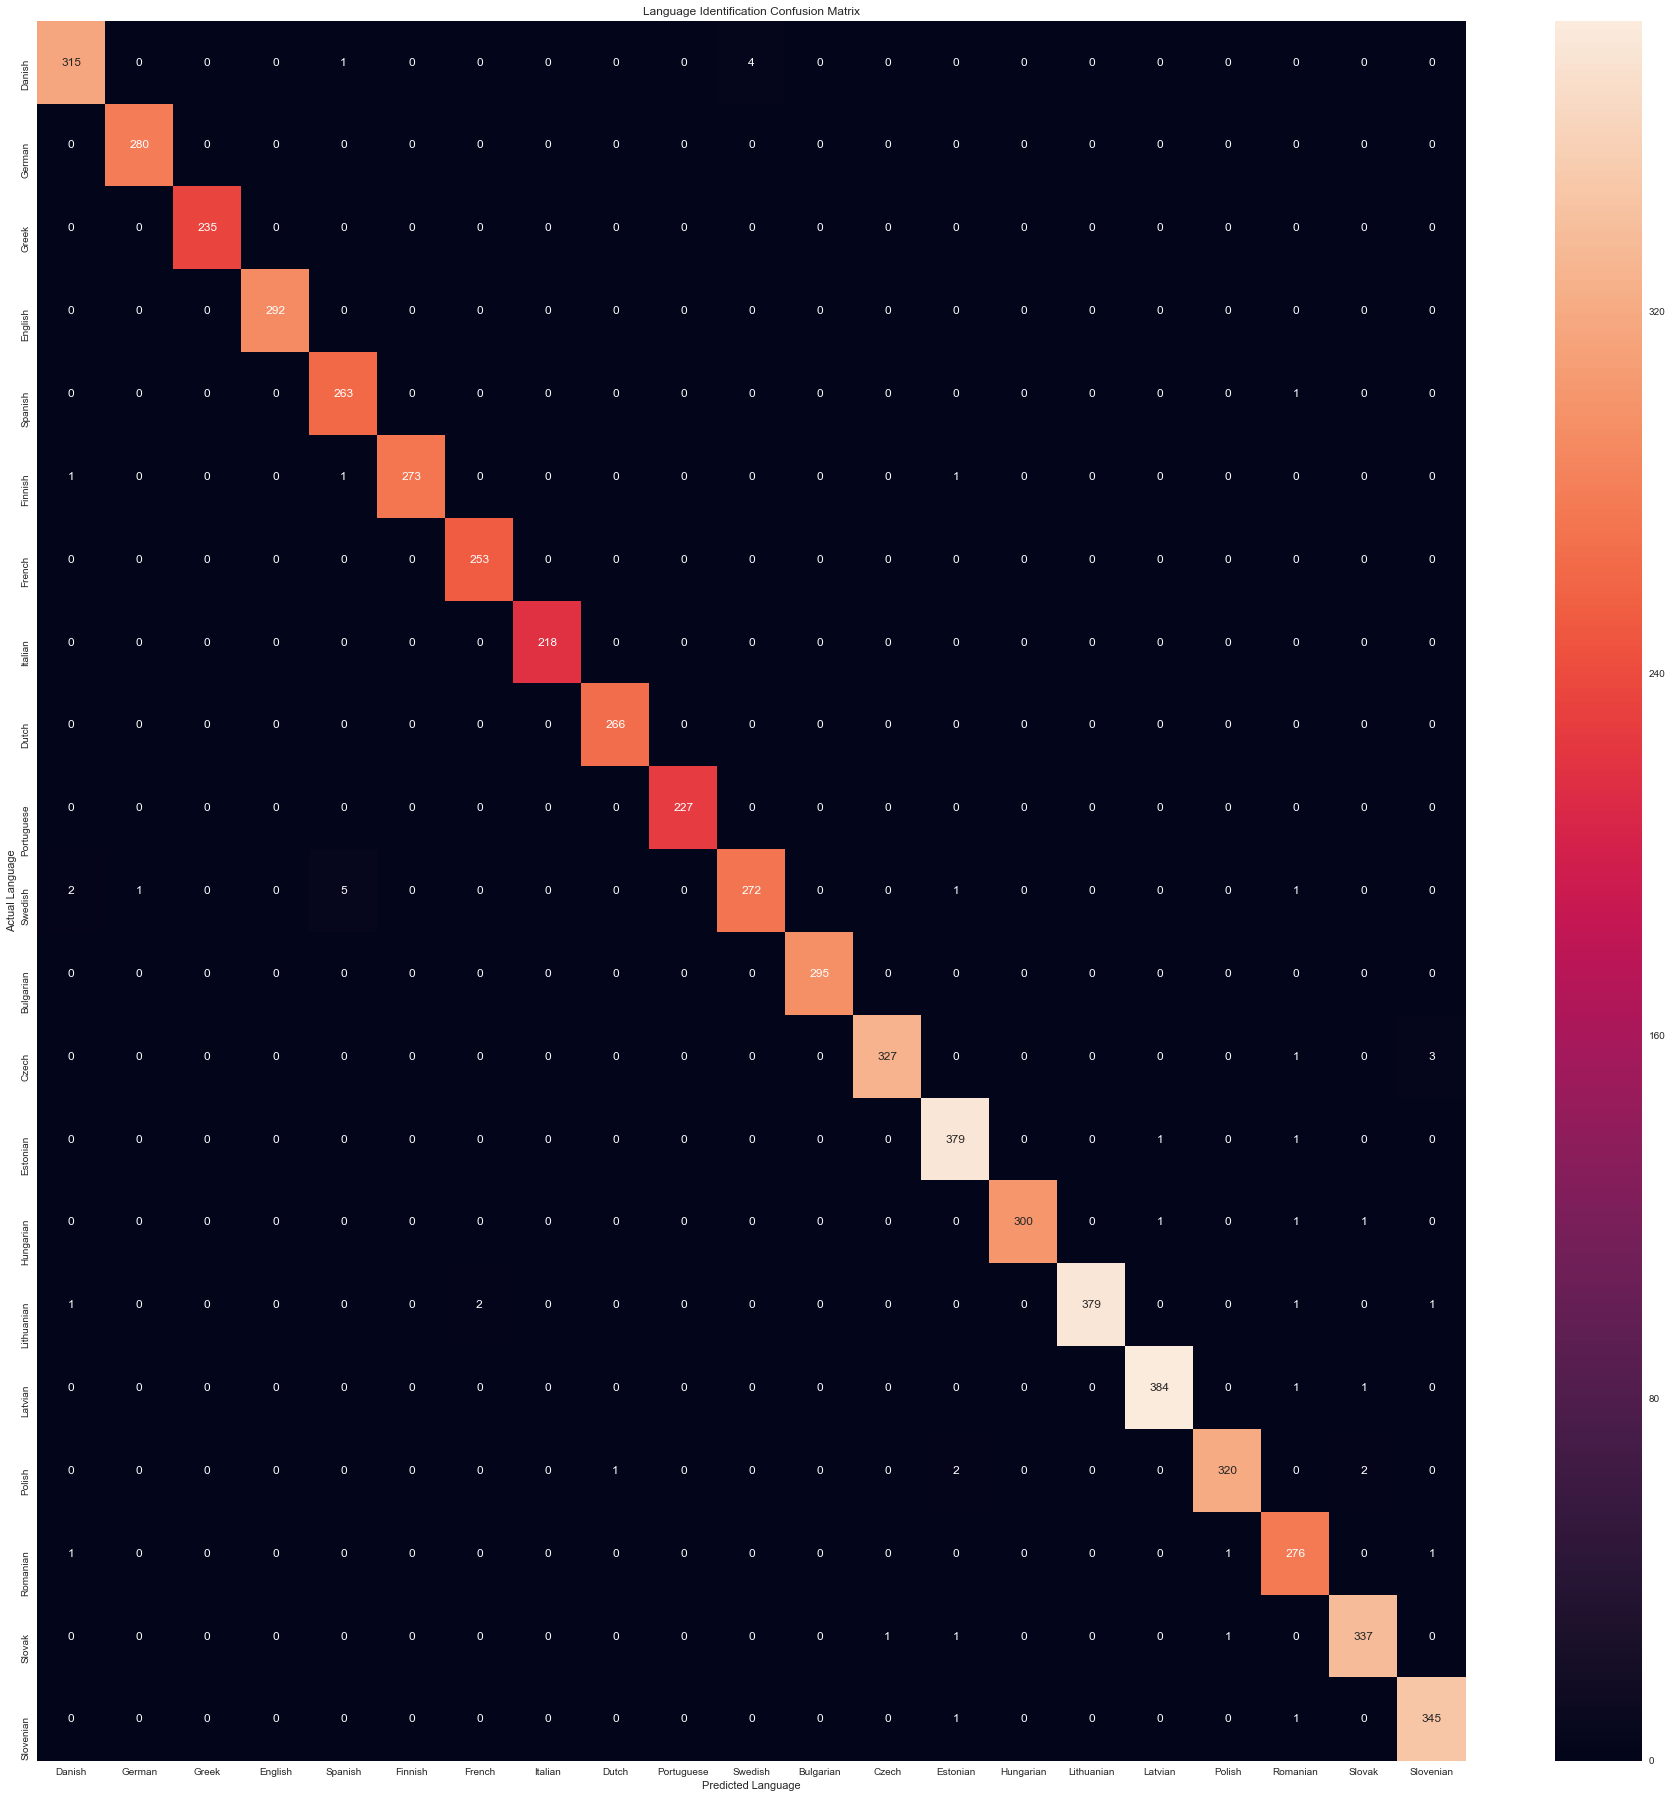

In [254]:
plt.show()

In [255]:
# Visualize Performance

test_languages(X_test, y_test, predictions)

Prediction: Romanian
Actual Language: Romanian
Input Sentence: 
Ei promovează o societate patriarhală, în care rolul femeii gravitează în jurul bucătăriei, leagănului şi bisericii.


Prediction: German
Actual Language: German
Input Sentence: 

Herr Präsident, Herr Kommissar, meine Damen und Herren!


Prediction: English
Actual Language: English
Input Sentence: 
The objective is to provide a framework and tool to support and enhance economic regeneration, to get the most effective use of resources in the widest partnership and to put these regions back on the road to recovery and sustainable development so that eventually they come off the regional life-support machine.


Prediction: Romanian
Actual Language: Romanian
Input Sentence: 
Dorim ca toate părţile vizate din Moldova, autorităţile oficiale, precum şi opoziţia politică şi societatea civilă, să se pună de acord şi să facă progrese în direcţia unei soluţii pentru criza actuală, care să aducă mai multă democraţie şi libertate, iar 

Actual Language: Polish
Input Sentence: 
NATO używała amunicji DU w trakcie swojej agresji przeciw Jugosławii.


Prediction: Slovak
Actual Language: Slovak
Input Sentence: 
Len takto dokážu naši spoluobčania, ktorí nás zvolili za svojich zástupcov, pochopiť, čo sa deje, a len tak im to budeme môcť vysvetliť.


Prediction: Polish
Actual Language: Polish
Input Sentence: 
Jest to kolejny krok w kierunku zarządzania gospodarczego i ogromnej ingerencji w suwerenność państw członkowskich.


Prediction: Italian
Actual Language: Italian
Input Sentence: 

Signor Presidente, indubbiamente la relazione dell' onorevole Schroedter contiene numerose osservazioni utili e mi congratulo con lei, ma resto del parere che, dinanzi agli orientamenti e ai risultati della politica regionale della Comunità, la nostra inquietudine dovrebbe essere anche maggiore.


Prediction: Greek
Actual Language: Greek
Input Sentence: 
Υπό τις συγκεκριμένες συνθήκες, θεωρώ ότι οι θέσεις είναι αρκετά σαφείς και θα καταγραφούν

Prediction: Swedish
Actual Language: Swedish
Input Sentence: 

Herr talman, herr kommissionär, kära kolleger!


Prediction: Latvian
Actual Language: Latvian
Input Sentence: 
Tās ir garantijas, ja mēs vēlamies novērst uzbrukumus vienotā tirgus integritātei vai ja mēs vēlamies novērst tādu instrumentu apšaubīšanu kā Stabilitātes un izaugsmes pakts.


Prediction: English
Actual Language: English
Input Sentence: 
Nevertheless, I would like to commend her on her work.


Prediction: Lithuanian
Actual Language: Lithuanian
Input Sentence: 
Tačiau tikimės išsamesnės ir ankstyvesnės informacijos bei konsultacijų.


Prediction: Estonian
Actual Language: Estonian
Input Sentence: 
Ma kiidan Euroopa Keskpanga presidenti, kes on tähelepanelikult jälginud Euroopa Parlamendi arutelusid ja raporteid ning tunnustab meie tegevussuunda ja otsusekindlust.


Prediction: Slovenian
Actual Language: Romanian
Input Sentence: 

7.


Prediction: Polish
Actual Language: Polish
Input Sentence: 

W jaki sposób Komisj

Dnă președintă, este puțin probabil ca planul de salvare pentru Irlanda să fie ultimul din zona euro, în ciuda declarațiilor făcute în acest sens.


Prediction: Dutch
Actual Language: Dutch
Input Sentence: 
De eerste conclusie is dat er op het vlak van de territoriale en sociale samenhang belangrijke vooruitgang is geboekt in de hele Unie en dat de communautaire fondsen een belangrijke, ofschoon geen doorslaggevende factor zijn geweest bij het verminderen van de regionale ongelijkheden.


Prediction: Lithuanian
Actual Language: Lithuanian
Input Sentence: 

Tačiau dėl pakto, atrodo, susiduriama su kai kuriais sunkumais bandant jį pajudinti iš mirties taško, nes Parlamentas turi susitvarkyti su didoku teisės aktų paketu.


Prediction: Czech
Actual Language: Czech
Input Sentence: 
Vděčíme za to všem ženám, které měly dostatek inteligence, síly a odvahy, aby se spojily a požadovaly volební právo, právo na práci a vzdělání.


Prediction: Dutch
Actual Language: Dutch
Input Sentence: 

Waarde

Prediction: Spanish
Actual Language: Spanish
Input Sentence: 
Espera de la Comisión que apruebe solamente los programas que hayan surgido de esa relación de partenariado.


Prediction: Estonian
Actual Language: Estonian
Input Sentence: 
Vaesestatud uraan on jääksaadus ning see on relvade valmistamiseks äärmiselt odav materjal.


Prediction: Estonian
Actual Language: Estonian
Input Sentence: 

Pakti näol võiks tegemist olla olulise lisapingutusega Euroopa õiglase ja jätkusuutliku majanduskasvu saavutamiseks, kui see on kooskõlas ühenduse juhtimissüsteemiga.


Prediction: Estonian
Actual Language: Estonian
Input Sentence: 
Tõsiseid julgeolekujõudude poolseid inimõiguste rikkumiste süüdistusi tuleb põhjalikult ning kiiresti uurida.


Prediction: Lithuanian
Actual Language: Lithuanian
Input Sentence: 

Nebenoriu gaišti laiko kalbėdamas institucijų klausimu.


Prediction: Slovak
Actual Language: Slovak
Input Sentence: 
Napriek tomu by som nechcel, aby Komisia budila dojem, že k problémom sú

Actual Language: Dutch
Input Sentence: 
De lidstaten moeten ook hun verantwoordelijkheid kennen.


Prediction: Slovak
Actual Language: Slovak
Input Sentence: 

Pokiaľ ide o štvrtú otázku, ktorá sa týka bezpečnostných záruk pre vojakov a civilistov zapojených do operácií Európskej únie, v tejto súvislosti by som chcel zdôrazniť, že za bezpečnostné záruky nesie zodpovednosť veliteľ operácie, v rámci operačného plánu schváleného Európskou radou, a tento veliteľ musí prijať opatrenia, ktoré považuje za nevyhnutné.


Prediction: French
Actual Language: French
Input Sentence: 
Je considère donc que la question orale reste maintenue à l' ordre du jour.


Prediction: Dutch
Actual Language: Dutch
Input Sentence: 
Het gevaar van een militaire coup is niet denkbeeldig.Wij weten niet wat er aan de hand is.


Prediction: Estonian
Actual Language: Estonian
Input Sentence: 
Kriisi vältel on eriesindaja pidanud tihedat sidet eesistujariigiga ning kõrge esindaja Javier Solanaga.


Prediction: Slovak
Ac

Input Sentence: 
Le premier concerne l'importance essentielle et centrale que nous continuons d'accorder au principe de la cohésion économique et sociale.


Prediction: Romanian
Actual Language: Romanian
Input Sentence: 
În şedinţa sa din 30 noiembrie 2009, Consiliul este aşteptat să adopte o serie de concluzii privind egalitatea de gen: consolidarea creşterii şi a ocupării forţei de muncă - contribuţie la Strategia de la Lisabona post-2010.


Prediction: French
Actual Language: French
Input Sentence: 
S'il ne reflète pas bien les positions, nous pourrons éventuellement le corriger.


Prediction: Bulgarian
Actual Language: Bulgarian
Input Sentence: 
Само през първите шест седмици се изплащат 60%, докато в продължение на 33 седмици се получава само символичен процент, а 13 седмици са неплатени.


Prediction: Latvian
Actual Language: Latvian
Input Sentence: 

("Zilās kartītes” jautājums Farage kungam saskaņā ar Reglamenta 149. panta 8. punktu) Priekšsēdētājas kundze, es ceru, ka Farage k

Input Sentence: 
Komu se torej lahko zahvalimo za to?


Prediction: Italian
Actual Language: Italian
Input Sentence: 
Il primo attiene all' importanza imprescindibile e centrale che continuiamo ad attribuire alla coesione economica e sociale.


Prediction: Slovak
Actual Language: Slovak
Input Sentence: 
Inými slovami, na Moldavsku a jeho občanoch nám záleží.


Prediction: Romanian
Actual Language: Romanian
Input Sentence: 

2.


Prediction: Swedish
Actual Language: Swedish
Input Sentence: 
Han behandlar frågan om harmonisering av examineringskraven för säkerhetsrådgivare för transport av farligt gods på väg, järnväg och inre vattenvägar.


Prediction: Polish
Actual Language: Polish
Input Sentence: 
Nigdy nie będzie przyzwolenia na brutalne traktowanie pokojowych demonstrantów.


Prediction: Bulgarian
Actual Language: Bulgarian
Input Sentence: 
Някои чуждестранни журналисти бяха изгонени или не бяха допуснати да влязат в страната.


Prediction: Finnish
Actual Language: Finnish
Input Sen


(Το Σώμα απορρίπτει την αίτηση με 164 ψήφους υπέρ, 166 ψήφους κατά και 7 αποχές)


Κυρία Πρόεδρε, θα ήθελα να ευχαριστήσω τον κ. Poettering για τη δημοσιότητα που έδωσε μόλις τώρα σε αυτή τη συζήτηση.


Prediction: Estonian
Actual Language: Estonian
Input Sentence: 
Meie asi on siis otsus teha ja teid toetada.


Prediction: Latvian
Actual Language: Latvian
Input Sentence: 

Trešais jautājums skar privātās dzīves apvienošanas iespējas ar profesionālo dzīvi.


Prediction: Portuguese
Actual Language: Portuguese
Input Sentence: 
Importa especialmente conseguir que as PME participem também nessas tarefas.


Prediction: English
Actual Language: English
Input Sentence: 
If they do not properly reflect the positions adopted, then we may correct them, if necessary.


Prediction: Romanian
Actual Language: Romanian
Input Sentence: 
În mod similar, statisticile din alte state membre sunt înşelătoare.


Prediction: Lithuanian
Actual Language: Lithuanian
Input Sentence: 
Pavyzdžiui, 2006 m. buvo pa

Toivomme, että komissio käsittelisi muutamia seikkoja, jotka liittyvät avun täydentävyyteen.


Prediction: Czech
Actual Language: Czech
Input Sentence: 

Za druhé, vyzýváme Komisi a členské státy, aby v rámci strategie Evropa 2020 učinily nezbytná opatření k odstranění nerovností mezi ženami a muži v oblasti zaměstnanosti.


Prediction: Bulgarian
Actual Language: Bulgarian
Input Sentence: 
Имаме огромно количество конкретни данни за това, които показват изборни измами.


Prediction: Romanian
Actual Language: Romanian
Input Sentence: 

Criza economică fără precedent și problema din ce în ce mai serioasă a imigrării se combină pentru a forma un cocteil toxic din care se hrănesc extremele și excesele.


Prediction: Slovak
Actual Language: Slovak
Input Sentence: 

Miera zadlženosti našich amerických a japonských partnerov ďaleko prevyšuje našu mieru zadlženosti, pričom treba povedať, že ich to veľmi neznepokojuje.


Prediction: Polish
Actual Language: Polish
Input Sentence: 
Jestem dumna z

Actual Language: Greek
Input Sentence: 

Προσβλέπουμε στην Επιτροπή για να ασχοληθεί με τα ζητήματα που αφορούν την προσθετικότητα.


Prediction: Czech
Actual Language: Czech
Input Sentence: 
V každém případě je zapotřebí urychlit práci na odborných studiích týkajících se účinků používání takovýchto zbraní na lidské bytosti.


Prediction: Czech
Actual Language: Czech
Input Sentence: 

Od roku 2001 jsme se my, Evropský parlament, snažili o zavedení moratoria.


Prediction: Slovak
Actual Language: Slovak
Input Sentence: 
Ak teraz dôjde k reštrukturalizácii v tom zmysle, že všetky operatívne rozhodnutia bude prijímať príslušný zodpovedný orgán, inými slovami Komisia, a zároveň sa zaručí demokratická legitimita prostredníctvom zapojenia Európskeho parlamentu, potom je všetko v poriadku.


Prediction: Latvian
Actual Language: Latvian
Input Sentence: 

Otrs jautājums ir par to, kādas izmaiņas Eiropas finanšu stabilizācijas instrumentā jūs uzskatāt par nepieciešamām, lai novērstu tādas apkaun

Actual Language: German
Input Sentence: 
Ich meine, es ist eine sehr gute Arbeit.


Prediction: Portuguese
Actual Language: Portuguese
Input Sentence: 

Lamentavelmente, a questão da segurança dos transportes tem sido tema de notícia nos últimos tempos: o choque ferroviário na estação de Paddington, em Londres, o terrível acidente ferroviário na Noruega, os dois acidentes de aviação entre cujas vítimas se encontravam cidadãos da União Europeia, e a catástrofe natural que provocou o acidente do Erika ao largo da costa da Bretanha - todos eles ocorridos no espaço de quatro meses -, alertam­nos para o facto de que a segurança dos meios de transporte jamais pode ser considerada um dado adquirido e que aqueles que têm a seu cargo a segurança do público devem ser profissionais altamente motivados e qualificados.


Prediction: Hungarian
Actual Language: Hungarian
Input Sentence: 
Az uránlövedékek, amikor felrobbannak finom, szennyező port bocsátanak ki; szennyezik a levegőt, a földet és a viz



Prediction: English
Actual Language: English
Input Sentence: 

Mr President, I would like to thank not only Mr Koch, but also the Vice-President of the Commission for the clear and unambiguous way in which they have declared their support for safety in the transport sector and acknowledged it as a priority.


Prediction: Italian
Actual Language: Italian
Input Sentence: 
Tanti sono gli incidenti in cui sono rimasti coinvolti camion che trasportavano merci pericolose e che in tali condizioni meteorologiche non avrebbero dovuto viaggiare invece di trovarsi tranquillamente sulle strade.


Prediction: Czech
Actual Language: Czech
Input Sentence: 
Jsem hrdá na skutečnost, že v tomto roce získala předsednictví Evropského parlamentu poprvé žena - Simone Veilová - odvážná zastánkyně ženských práv.


Prediction: Danish
Actual Language: Danish
Input Sentence: 
Og det er først begyndelsen.


Prediction: Danish
Actual Language: Danish
Input Sentence: 
fru Sudre og hr.


Prediction: Slovenian
Actu

Prediction: Polish
Actual Language: Polish
Input Sentence: 

(RO) Na wydarzenia, do których doszło w Republice Mołdawii, zanosiło się już od dawna.


Prediction: English
Actual Language: English
Input Sentence: 
Indeed, I had occasion recently to say as much to all the ministers responsible for urban policy at a meeting in Tampere.


Prediction: English
Actual Language: English
Input Sentence: 

These are the reasons why the guidelines are presented according to thematic priorities, since they must be taken into consideration, under each of the objectives, to different extents in accordance with the specific situations of each of the Member States and regions.


Prediction: French
Actual Language: French
Input Sentence: 

Nous invitons les États membres qui n'ont pas encore déposé de liste des zones éligibles à le faire dans les plus brefs délais et attendons naturellement de la Commission qu'elle examine rapidement les programmes opérationnels des régions pour la période 2000-2006 à l

Input Sentence: 
Det er specielt vigtigt at inddrage de små og mellemstore virksomheder i planlægningen og gennemførelsen af programmerne.


Prediction: Greek
Actual Language: Greek
Input Sentence: 
Έτσι, πρότεινα το όριο ψύχους να μειωθεί στους - 40 βαθμούς.


Prediction: Latvian
Actual Language: Latvian
Input Sentence: 
Otrkārt, lai būtu par Eiropas komisāru, jums ir jābūt profesionālam optimistam, vismaz, ja jūs esat atbildīgs par ES paplašināšanu un attiecībām ar Dienvidaustrumeiropu.


Prediction: Slovenian
Actual Language: Slovenian
Input Sentence: 
Lahko si kar predstavljam, da sta Irska ali Grčija v hudih škripcih.


Prediction: Bulgarian
Actual Language: Bulgarian
Input Sentence: 
Кризата показа необходимостта от засилване на помощта на ЕС, насочена към по-нататъшни политически и икономически реформи в Молдова, с цел укрепване на ангажираността на Молдова към демократичните стандарти и ценности и в съответствие с подкрепата на ЕС по въпроса за суверенитета и териториалната цял

Prediction: Portuguese
Actual Language: Portuguese
Input Sentence: 

Senhor Presidente, gostaria de agradecer não só ao colega Koch, mas também à Vice-presidente da Comissão por ter aderido de forma tão clara e inequívoca à segurança no domínio do transporte e à prioridade da segurança.


Prediction: Danish
Actual Language: Danish
Input Sentence: 

Jeg vil gerne have, at vi får mulighed for at forberede os fornuftigt på en debat om femårsprogrammet i grupperne.


Prediction: German
Actual Language: German
Input Sentence: 
Ich glaube, wir können dies ruhig laut und deutlich sagen.


Prediction: Estonian
Actual Language: Estonian
Input Sentence: 
Sellepärast keskendume neile, mille mõju süütule tsiviilelanikkonnale võib olla kõige kahjulikum.


Prediction: Hungarian
Actual Language: Hungarian
Input Sentence: 

Beszélt az egyiptomi és más országokban végbe menő eseményekről, és közben elmondta, hogy csodálatos, ahogyan az emberek fellázadnak a demokráciáért.


Prediction: Swedish
Actual L

Те са гаранцията за избягване на атаките върху целостта на единния пазар, или за да не бъдат поставяни под въпрос други механизми, като например Пактът за стабилност и растеж.


Prediction: Danish
Actual Language: Danish
Input Sentence: 
Berend og lykønske ham for kvaliteten af det arbejde, han har udført.


Prediction: English
Actual Language: English
Input Sentence: 

Finally, and in order to respond to the concerns which you have expressed in this House, particularly yourself, Mrs Schroedter, in these guidelines we recall the importance and the definition of integrated strategies, for development or redevelopment, which, of all the priorities, offer the maximum opportunity to synergy, to the measures undertaken and to the establishment of a decentralised partnership.


Prediction: Polish
Actual Language: Polish
Input Sentence: 
Dlatego też apelujemy do innych krajów UE, aby podążyły z ich przykładem i przedłożyły sprawozdania zdrowotne zgodnie z wnioskiem ONZ.


Prediction: Dutch
Ac

Actual Language: Hungarian
Input Sentence: 
Ennek ellenére Lettországban hónapokon keresztül követelték, hogy a koalíció minisztereként vállaljak politikai felelősséget ezekért az eseményekért.


Prediction: Hungarian
Actual Language: Hungarian
Input Sentence: 

Németország mit tett saját válsága legsötétebb órájában?


Prediction: Italian
Actual Language: Italian
Input Sentence: 
Perciò raccomandiamo - e ho l'impressione che anche la Commissione sia disposta ad accogliere questa idea - di discutere in febbraio il programma a lungo termine della Commissione che si estende fino al 2005 - sperando che a quel punto la Commissione abbia concordato un programma che ci sottoporrà - e, sempre in febbraio, anche il programma legislativo della Commissione per l'anno 2000.


Prediction: Slovenian
Actual Language: Slovenian
Input Sentence: 
To so vsa legitimna vprašanja in nanje moramo odgovoriti jasno.


Prediction: Italian
Actual Language: Italian
Input Sentence: 
Il nostro gruppo appoggia l'ap



Prediction: Latvian
Actual Language: Latvian
Input Sentence: 
Pašreizējā krīze ir pārbaudījums tam, kā Moldova risinās šo jautājumu.


Prediction: Finnish
Actual Language: Finnish
Input Sentence: 

Suurin osa Walesia, kuten tiedätte, on rakennerahastoille esitetyssä ohjelmasuunnitelmassa katsottu kuuluvaksi tavoitteeseen 1.


Prediction: Portuguese
Actual Language: Portuguese
Input Sentence: 
Os esforços orientados para o aumento do PIB por habitante nas regiões do objectivo 1 nem sempre têm como resultado esse aumento.


Prediction: Spanish
Actual Language: Spanish
Input Sentence: 
Así, por ejemplo, en la parte central de los fondos estructurales se ha olvidado, sin más, el partenariado.


Prediction: Danish
Actual Language: Danish
Input Sentence: 
Det er uhyre vigtigt, at den nyeste teknik og knowhow overføres til anvendelse i virksomheder i de regioner, som udvikles langsommere.


Prediction: Slovenian
Actual Language: Slovenian
Input Sentence: 
- Gospa predsednica, to je zares ob



Prediction: Danish
Actual Language: Danish
Input Sentence: 
Efter min mening var det fremragende.


Prediction: Dutch
Actual Language: Dutch
Input Sentence: 

Ik wil erop wijzen, mevrouw de Voorzitter, dat dat debat zich volgens het in septembere bereikte akkoord zou onderscheiden van het debat over het jaarlijks wetgevingsprogramma van de Commissie.


Prediction: Latvian
Actual Language: Latvian
Input Sentence: 
Tā ir cerība, ka mēs panāksim nepieciešamās pārmaiņas.


Prediction: English
Actual Language: English
Input Sentence: 
This makes it necessary to also take account of the ways in which materials and packaging are affected by cold of this kind.


Prediction: English
Actual Language: English
Input Sentence: 

We understand that it is important that the two institutions - Parliament and Commission - cooperate and work together and that the current cooperation with the Committee on Regional Policy, and in particular the transport group, is magnificent.


Prediction: Swedish
Actu


Finalmente quisiera comentar una tercera cosa que también es importante, esto es, una enmienda presentada por el diputado Ari Vatanen.


Prediction: Spanish
Actual Language: Spanish
Input Sentence: 

Escuchemos ahora al Sr. Wurtz, que hablará en contra de la petición.


Prediction: Lithuanian
Actual Language: Lithuanian
Input Sentence: 
ES yra pasirengusi bendradarbiauti ir priartinti Moldovą prie ES.


Prediction: Danish
Actual Language: Danish
Input Sentence: 
Hvorfor er der ingen brandinstrukser?


Prediction: Slovenian
Actual Language: Slovenian
Input Sentence: 

podpredsednica Komisije.


Prediction: Hungarian
Actual Language: Hungarian
Input Sentence: 
A kisinyovi megtorlás mára a hatóságok számára a lakossággal való kommunikáció eszközévé vált.


Prediction: Portuguese
Actual Language: Portuguese
Input Sentence: 
A migração descontrolada, por exemplo, não foi suficientemente considerada.


Prediction: Swedish
Actual Language: Swedish
Input Sentence: 

Arbetsplan

Nästa punkt på

Actual Language: Spanish
Input Sentence: 
Mínima, si no inexistente, es la atención que se presta a los enormes problemas de las regiones insulares de la Unión, cuyas deficiencias en infraestructuras, transportes, comunicaciones y energía conducen indefectiblemente a la despoblación.


Prediction: Danish
Actual Language: Danish
Input Sentence: 

Og nu til indholdet.


Prediction: German
Actual Language: German
Input Sentence: 

Die EU hat diesen Respekt wirklich verdient.


Prediction: Spanish
Actual Language: Spanish
Input Sentence: 

Quiero decir, señora Presidenta, que este debate se distinguía, en el acuerdo al que se llegó en el mes de septiembre, de lo que es la presentación anual del programa legislativo de la Comisión.


Prediction: German
Actual Language: German
Input Sentence: 

Herr Präsident, Herr Kommissar!


Prediction: Latvian
Actual Language: Latvian
Input Sentence: 
Mēs esam iesaistīti daudzās kopīgās attīstības programmās, un es domāju, ka Rumānijai un Eiropas Savienī


Prediction: Slovenian
Actual Language: Slovenian
Input Sentence: 

v imenu skupine ALDE.- (FR) Tako ne bo šlo.


Prediction: Finnish
Actual Language: Finnish
Input Sentence: 
Ensimmäinen koskee sitä, että alueellisessa ja sosiaalisessa yhteenkuuluvuudessa on saavutettu merkittävää edistymistä koko unionin alueella ja että yhteisön rahastot ovat olleet tärkeä, vaikkakaan ei ratkaiseva tekijä tasoitettaessa alueiden välistä epätasa-arvoa.


Prediction: Polish
Actual Language: Polish
Input Sentence: 
Pod względem instytucjonalnym cała koncepcja jest zła od samego początku.


Prediction: Danish
Actual Language: Danish
Input Sentence: 
Dog mener jeg, at henvisningen til en egentlig konvergens med hensyn til regional udvikling i Europa giver en lidt ufuldstændig opfattelse af situationen, og det er desværre ofte det budskab, der gentages i pressen og i visse taler.


Prediction: French
Actual Language: French
Input Sentence: 
Nous avons ensuite procédé à un vote, chaque président ou préside

Input Sentence: 
Me vastustamme unionin ja sen jäsenvaltioiden keskushallinnon liiallista holhousta ja vaadimme ohjelmien laatimiseen ja toteuttamiseen pesiytyneen byrokratian vähentämistä.


Prediction: German
Actual Language: German
Input Sentence: 

Diese Zusage ist insofern von Bedeutung, als die Kommission ein Organ ist, das nach den Verträgen das Initiativmonopol besitzt und somit grundlegend die politische und legislative Tätigkeit dieses Parlaments in den nächsten fünf Jahren gestaltet.


Prediction: English
Actual Language: English
Input Sentence: 
This would be necessary to keep safety standards at the level they were in northern regions previously.


Prediction: English
Actual Language: English
Input Sentence: 
Let us not forget either that greater consideration should be given to the islands and remote regions of the European Union because their geographical location is a hindrance to their economic and social development, unless of course the Commission is intending to bui

Input Sentence: 

Arvoisa puhemies, siitä ei ole epäilystäkään, etteikö Schroedterin mietintöön sisältyisi tärkeitä huomioita, ja onnittelen tästä esittelijää.


Prediction: Spanish
Actual Language: Spanish
Input Sentence: 
Por lo que a mí personalmente respecta estoy completamente de acuerdo.


Prediction: Czech
Actual Language: Czech
Input Sentence: 
Nyní bych se chtěla zeptat Komise a Rady, jaká opatření přijmou s cílem zevšeobecnit moratorium a podpořit všeobecný zákaz.


Prediction: Italian
Actual Language: Italian
Input Sentence: 

Signora Presidente, mi permetta di formulare un paio di osservazioni.


Prediction: Spanish
Actual Language: Spanish
Input Sentence: 
En este aspecto del equilibrio del mundo rural, no olvidemos que también existe la nueva política de desarrollo rural, cofinanciada por el FEOGA "Garantía" , cuyo papel es el de promover la reforma de la agricultura europea y sostener la dimensión multifuncional de la agricultura.


Prediction: Swedish
Actual Language: S

Input Sentence: 
Posso anche accettare queste norme minime, ma esorto la Commissione a esercitare un'attenta sorveglianza.


Prediction: Romanian
Actual Language: Romanian
Input Sentence: 
Restul voturilor s-au împărţit între cele trei partide de opoziţie.


Prediction: Danish
Actual Language: Danish
Input Sentence: 
Simpson så rigtigt sagde, kan man aldrig tage processen for givet, for gennemført eller for kulmineret.


Prediction: English
Actual Language: English
Input Sentence: 



The debate is closed.


Prediction: Finnish
Actual Language: Finnish
Input Sentence: 
Keskimääräisen bruttokansantuotteen välinen ero on pienentynyt kymmenessä vuodessa kymmenellä prosenttiyksiköllä.


Prediction: Latvian
Actual Language: Latvian
Input Sentence: 

Starptautisks nolīgums par urāna ieroču aizliegumu (debates) 

Nākamais darba kārtības jautājums ir debates par:

Elly de Groen-Kouwenhoven, Angelika Beer un Carolina Lucas Verts/ALE grupas vārdā, Luisa Morgantini GUE/NGL grupas vārdā, Annemie N

Prediction: Finnish
Actual Language: Finnish
Input Sentence: 
Se tarkoittaa, että tarvitaan myös lukuisia tukitoimia, jotta näillä alueilla voidaan ylipäätään tehdä jotakin.


Prediction: English
Actual Language: English
Input Sentence: 
There is support for the EU in Lapland also, so let us remember them.


Prediction: Italian
Actual Language: Italian
Input Sentence: 
Tutti gli altri erano di diversa opinione e così è stato deciso.


Prediction: Portuguese
Actual Language: Portuguese
Input Sentence: 

A votação terá lugar amanhã, às 12H00.


Prediction: Lithuanian
Actual Language: Lithuanian
Input Sentence: 
protokolą)

(La sesión, suspendida a las 13.10 horas, se reanuda a las 15.00 horas)

Klausimai, į kuriuos atsakoma žodžiu, ir rašytiniai pareiškimai (gauti dokumentai) (žr.


Prediction: Polish
Actual Language: Polish
Input Sentence: 

Trzecie i ostatnie pytanie: w jaki sposób, Pana zdaniem, przywrócimy zaufanie, skoro wszystkie decyzje dotyczące polityki pieniężnej - i ostatnie p

Actual Language: Dutch
Input Sentence: 
Mevrouw de rapporteur, geachte afgevaardigden, iedereen kent de redenen van het oponthoud.


Prediction: Danish
Actual Language: Danish
Input Sentence: 
Jeg beklager dette, for vi skal være aktive, fordi andre ikke har gjort deres arbejde.


Prediction: Polish
Actual Language: Polish
Input Sentence: 

Moim zdaniem my, Europejczycy, od miesięcy mamy do czynienia z sytuacją poważniejszą niż kryzys walutowy, ale oprócz niego zmagamy się również z kryzysem zdolności naszych rządów do przyjęcia wspólnej odpowiedzialności za ten problem i zastosowania wspólnej strategii, która mogłaby pomóc nam przezwyciężyć te trudności.


Prediction: Spanish
Actual Language: Spanish
Input Sentence: 

Como mi Grupo opina que un Parlamento está hecho para escuchar, para debatir y para reflexionar, pensamos que no hay razón alguna que justifique este aplazamiento y creemos que si, la Comisión está en condiciones de hacerlo, estamos perfectamente a tiempo para poder rest


Prediction: Latvian
Actual Language: Latvian
Input Sentence: 

Parlamenta procedūras neļauj šai institūcijai ātri pieņemt lēmumus, bet Eiropas Parlamenta deputāti ir iesnieguši priekšlikumus, kas Eiropadomei varētu būt noderīgi.


Prediction: Hungarian
Actual Language: Hungarian
Input Sentence: 

Hiszem, hogy az Európai Uniónak érdeke, hogy a Moldovai Köztársaság európai utat kövessen, és tartson lépést polgárainak azon törekvésével, hogy egy szilárd, biztonságos és demokratikus államban élhessenek.


Prediction: Estonian
Actual Language: Estonian
Input Sentence: 
Me tunneme Moldova püüdu Euroopa poole.


Prediction: Estonian
Actual Language: Estonian
Input Sentence: 
Ma ütleks, et see näitab üsna hästi praegust olukorda maailmas.


Prediction: Greek
Actual Language: Greek
Input Sentence: 
Επιφυλάσσομαι επομένως, αν δεν σας πειράζει κύριε βουλευτή, να σας δηλώσω την άποψή μου, η οποία συντάσσεται σε μεγάλο βαθμό με τη δική σας σύσταση σχετικά με το τι μπορούμε να πράξουμε για να καταπ

Diese Prioritäten sollen - wie hier mehrfach gefordert wurde - zu einer bessern Nutzung, einer optimalen, effizienten Nutzung der Gemeinschaftsinterventionen beitragen; dazu gehört gegebenenfalls auch die Leistungsreserve, Herr Bradbourn, die insbesondere das Ziel hat, eine optimale und effiziente Verwendung der öffentlichen Gelder Europas sicherzustellen.


Prediction: Portuguese
Actual Language: Portuguese
Input Sentence: 
Por conseguinte, contamos com os programas dos Fundos Estruturais não apenas para nos ajudar na reestruturação do nosso sector industrial, mas também para assegurar uma melhoria mais abrangente do tecido económico de base em todo o Principado.


Prediction: Estonian
Actual Language: Estonian
Input Sentence: 
- (CS) Vaesestatud uraani sisaldavad relvad on keskkonnale tohutuks koormaks.


Prediction: Lithuanian
Actual Language: Lithuanian
Input Sentence: 
Atrodytų, kad siekiama didinti šalies kredito reitingą tiems, kurie ketina suteikti paskolą, pasakant, kad jie pr

Prediction: Czech
Actual Language: Czech
Input Sentence: 
Musíme však jít ještě dále a zajistit, aby jak Parlament, tak Komise vykonávaly všechna práva, jimž se v tomto ohledu těší, a v tomto spoléháme na předsedu Komise.


Prediction: Czech
Actual Language: Czech
Input Sentence: 

(RO) Paní předsedající, dámy a pánové, máme s Moldavskou republikou tři problémy, všechny tři vážné, pro něž můžeme navrhnout tři druhy opatření.


Prediction: Danish
Actual Language: Danish
Input Sentence: 
Tag ved revisionen, ved tildelingen af midler, strategisk hensyn til beskæftigelsesbehovene, for det er, når alt kommer til alt, hvad strukturfondene og Samhørighedsfonden kræver.


Prediction: Romanian
Actual Language: Romanian
Input Sentence: 
Propunerea de rezoluţie se concentrează în mod îndreptăţit asupra urmăririi în justiţie a făptaşilor.


Prediction: Hungarian
Actual Language: Hungarian
Input Sentence: 
Mindez történik azután, hogy Barroso úr előtte hetekig kritizálta Merkel kancellárt, hogy nem